<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/Preprocessing_of_datasets_Environmental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [93]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
import scipy.io
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import boxcox
%pylab inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
sns.set()

In [4]:
working_path = Path('/content/gdrive/MyDrive/CoganLab/Environmental/healthy')

In [5]:
!ls /content/gdrive/MyDrive/CoganLab/Environmental/healthy

E32_Block_1_TrialData.mat  E39_Block_1_TrialData.mat  E45_Block_1_TrialData.mat
E34_Block_1_TrialData.mat  E40_Block_1_TrialData.mat  E46_Block_1_TrialData.mat
E35_Block_1_TrialData.mat  E41_Block_1_TrialData.mat  eeg_envir.csv
E36_Block_1_TrialData.mat  E42_Block_1_TrialData.mat  ieeg_envir.csv
E37_Block_1_TrialData.mat  E43_Block_1_TrialData.mat
E38_Block_1_TrialData.mat  E44_Block_1_TrialData.mat


In [69]:
eeg = pd.read_csv(
    working_path.joinpath('eeg_envir.csv'),
    index_col=None
)
ieeg = pd.read_csv(
    working_path.joinpath('ieeg_envir.csv'),
    index_col=None
)

In [91]:
# checking significance with ttests
def ttest(x, y):
  if len(x) == len(y):
    return stats.ttest_ind(x, y, equal_var = True)
  else:
    return stats.ttest_ind(x, y, equal_var = False)

## iEEG

In [7]:
ieeg.shape

(3464, 28)

In [8]:
ieeg[~ieeg['ProbeType'].isnull()].Subject.unique()

array(['D27'], dtype=object)

In [9]:
ieeg[~ieeg['ProbeType'].isnull()].shape

(160, 28)

In [10]:
ieeg_preprocess = ieeg[ieeg['ProbeType'].isnull()]

In [11]:
ieeg_preprocess.shape

(3304, 28)

In [12]:
ieeg_ = ieeg_preprocess[[
    'block', 'StimlusCategory',
       'ReactionTime', 'KeyCode', 'Resp', 'RespCorrect',
       'stimulusSounds_idx', 'ProbeCategory', 'probeSound_idx',
       'StimulusCategory', 'Trial',
       'Subject'
]]

In [13]:
# getting rid of additional lists
values = []
col = ieeg_.block.values
for i in col:
  values.append(i[1:2])
ieeg_['block'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
values = []
col = ieeg_.ReactionTime.values
for i in col:
  values.append(float(i[1:-1]))
ieeg_['ReactionTime'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
values = []
col = ieeg_.KeyCode.values
for i in col:
  if i == '[nan]':
    values.append(np.nan)
  else:
    values.append(int(i[1:-1]))
ieeg_['KeyCode'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
values = []
col = ieeg_.RespCorrect.values
for i in col:
  values.append(int(i[1:-1]))
ieeg_['RespCorrect'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [17]:
values = []
col = ieeg_.stimulusSounds_idx.values
for i in col:
  values.append(int(i[1:-1]))
ieeg_['stimulusSounds_idx'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
values = []
col = ieeg_.ProbeCategory.values
for i in col:
  values.append(int(i[1:-1]))
ieeg_['ProbeCategory'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [19]:
values = []
col = ieeg_.probeSound_idx.values
for i in col:
  values.append(int(i[1:-1]))
ieeg_['probeSound_idx'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Uniting two columns for stimulus category

In [20]:
ieeg_.head()

,block,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,StimulusCategory,Trial,Subject
160,1,nonwords,0.990436,39.0,No,1,3,0,14,NaN,0,D28
161,1,words,1.302180,37.0,Yes,1,16,1,11,NaN,1,D28
162,1,environment,1.432630,37.0,Yes,1,17,1,7,NaN,2,D28
163,1,environment,1.160734,37.0,Yes,1,17,1,13,NaN,3,D28
164,1,environment,0.845712,37.0,Yes,1,16,1,3,NaN,4,D28


In [21]:
stim1 = ieeg_.StimlusCategory.values
stim2 = ieeg_.StimulusCategory.values

In [22]:
categories = []
for i in range(0, ieeg_.shape[0]):
  if pd.isna(stim1[i]) is True:
    if pd.isna(stim2[i]) is False:
      categories.append(stim2[i])
    else:
      print('Check')
  elif pd.isna(stim1[i]) is False:
    if pd.isna(stim2[i]) is True:
      categories.append(stim1[i])
    else:
      print('Check')  

In [23]:
ieeg_['StimulusCategory'] = categories

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
ieeg_ = ieeg_.loc[:, ieeg_.columns != 'StimlusCategory']

iEEG dataset has 'None' responses in the column 'Resp'. Reaction times corresponding to these trial are identical and either 2500 ms or 4000 ms. This is our No response trials, that we will treat as incorrect in Accuracy analysis and will get rid of them for RT analysis.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


227

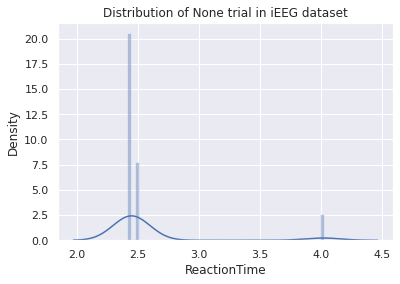

In [25]:
sns.distplot(ieeg_[ieeg_['Resp'] == 'None']['ReactionTime'])
pl.title('Distribution of None trial in iEEG dataset');
ieeg_[ieeg_['Resp'] == 'None']['ReactionTime'].count()

In [26]:
print(
    'Accuracy without "No response" trials',
    ieeg_[ieeg_['Resp'] != 'None'].RespCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    ieeg_.RespCorrect.mean()
)

Accuracy without "No response" trials 0.8199545011374716
Accuracy with "No response" trials 0.7636198547215496


In [27]:
print('Shape of the dataset with no response trials', ieeg_.shape)
print('Shape of the dataset without no response trials', ieeg_[ieeg_['Resp'] != 'None'].shape)

Shape of the dataset with no response trials (3304, 11)
Shape of the dataset without no response trials (3077, 11)


In [28]:
checkset = ieeg_.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
checkset[checkset['RespCorrect'] < 0.70]

,RespCorrect
Subject,
D37,0.672619
D41,0.428571
D54,0.488095


In [29]:
ieeg_ = ieeg_[
    (ieeg_['Subject'] != 'D37') &
    (ieeg_['Subject'] != 'D41') &
    (ieeg_['Subject'] != 'D54')    
]

In [30]:
print(
    'Accuracy without "No response" trials',
    ieeg_[ieeg_['Resp'] != 'None'].RespCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    ieeg_.RespCorrect.mean()
)

Accuracy without "No response" trials 0.8371057513914657
Accuracy with "No response" trials 0.8057142857142857


Mean 1.1499551733654916 Max 3.85388986 Min 0.28821655


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


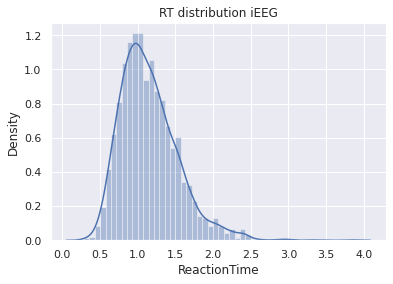

In [31]:
sns.distplot(ieeg_[ieeg_['Resp'] != 'None'].ReactionTime)
pl.title('RT distribution iEEG');
print(
    'Mean', ieeg_[ieeg_['Resp'] != 'None'].ReactionTime.mean(),
    'Max', ieeg_[ieeg_['Resp'] != 'None'].ReactionTime.max(),
    'Min', ieeg_[ieeg_['Resp'] != 'None'].ReactionTime.min()
)

In [32]:
ieeg_[(ieeg_['Resp'] != 'None') & (ieeg_['ReactionTime'] > 2.5)]

,block,ReactionTime,KeyCode,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,StimulusCategory,Trial,Subject
293,1,3.009802,37.0,Yes,1,10,1,10,nonwords,13,D30
317,2,2.618975,39.0,No,1,14,0,2,environment,37,D30
320,2,3.319305,39.0,No,0,2,1,9,nonwords,40,D30
383,5,2.919165,37.0,Yes,0,12,0,2,nonwords,103,D30
384,5,2.841524,37.0,Yes,1,1,1,10,words,104,D30
399,5,2.972747,37.0,Yes,1,4,1,4,nonwords,119,D30
432,7,2.595327,37.0,Yes,0,16,0,8,words,152,D30
578,6,3.853890,39.0,No,0,7,1,9,environment,130,D31


## EEG dataset

In [70]:
eeg.columns

Index(['Unnamed: 0', 'block', 'StimulusCategory', 'ReactionTime', 'KeyCode',
       'Resp', 'RespCorrect', 'stimulusAudioStart', 'stimulusAlignedTrigger',
       'probeAudioStart', 'probeAlignedTrigger', 'stimulusSounds_idx',
       'stimulusSounds_name', 'ProbeCategory', 'probeSound_idx',
       'probeSound_name', 'responseAlignedTrigger', 'trialOrder_All',
       'ListenCueOnset', 'MaintenancePeriodOnset', 'ProbeCueOnset', 'Trial',
       'Subject'],
      dtype='object')

In [71]:
eeg_ = eeg[[
    'block', 'StimulusCategory', 'ReactionTime', 'KeyCode',
       'Resp', 'RespCorrect', 'stimulusSounds_idx',
       'ProbeCategory', 'probeSound_idx',
       'Trial', 'Subject'
]]

In [72]:
# getting rid of additional lists
values = []
col = eeg_.block.values
for i in col:
  values.append(int(i[1:-1]))
eeg_['block'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
values = []
col = eeg_.ReactionTime.values
for i in col:
  values.append(float(i[1:-1]))
eeg_['ReactionTime'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [74]:
values = []
col = eeg_.RespCorrect.values
for i in col:
  values.append(int(i[1:-1]))
eeg_['RespCorrect'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [75]:
values = []
col = eeg_.stimulusSounds_idx.values
for i in col:
  values.append(int(i[1:-1]))
eeg_['stimulusSounds_idx'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [76]:
values = []
col = eeg_.ProbeCategory.values
for i in col:
  values.append(int(i[1:-1]))
eeg_['ProbeCategory'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [77]:
values = []
col = eeg_.probeSound_idx.values
for i in col:
  values.append(int(i[1:-1]))
eeg_['probeSound_idx'] = values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Preprocessing the data

In [78]:
print(
    'Accuracy without "No response" trials',
    eeg_[eeg_['Resp'] != 'None'].RespCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    eeg_.RespCorrect.mean()
)

Accuracy without "No response" trials 0.8842105263157894
Accuracy with "No response" trials 0.8703208556149733


In [79]:
print('Shape of the dataset with no response trials', eeg_.shape)
print('Shape of the dataset without no response trials', eeg_[eeg_['Resp'] != 'None'].shape)

Shape of the dataset with no response trials (2992, 11)
Shape of the dataset without no response trials (2945, 11)


In [80]:
eeg_[eeg_['Resp'] == 'None'].shape

(47, 11)

In [81]:
eeg_.head()

,block,StimulusCategory,ReactionTime,KeyCode,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,Trial,Subject
0,1,nonwords,1.160933,3.Left,No,1,58,0,72,0,E32
1,1,environment,0.962195,2.Left,Yes,1,23,1,23,1,E32
2,1,words,0.847072,2.Left,Yes,1,31,1,31,2,E32
3,1,nonwords,1.023422,2.Left,Yes,1,62,1,67,3,E32
4,1,nonwords,1.607325,2.Left,Yes,1,56,1,68,4,E32


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


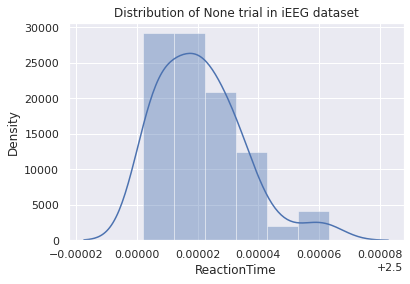

In [82]:
sns.distplot(eeg_[eeg_['Resp'] == 'None']['ReactionTime'])
pl.title('Distribution of None trial in iEEG dataset');

In [83]:
checkset = eeg_.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
checkset[checkset['RespCorrect'] < 0.70]

,RespCorrect
Subject,


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean 0.9929041114329372 Max 2.44919808 Min 0.39225969


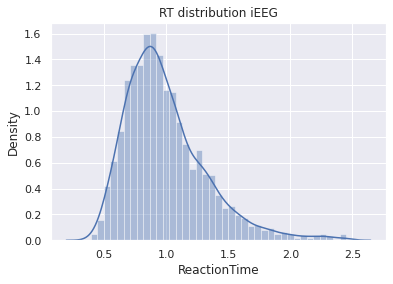

In [85]:
sns.distplot(eeg_[eeg_['Resp'] != 'None'].ReactionTime)
pl.title('RT distribution iEEG');
print(
    'Mean', eeg_[eeg_['Resp'] != 'None'].ReactionTime.mean(),
    'Max', eeg_[eeg_['Resp'] != 'None'].ReactionTime.max(),
    'Min', eeg_[eeg_['Resp'] != 'None'].ReactionTime.min()
)

## Accuracy plots. EEG

NW vs W
Ttest_indResult(statistic=-0.4284474906807684, pvalue=0.6683716818900234)
NW vs Environment
Ttest_indResult(statistic=0.2554350291355636, pvalue=0.798413506113592)
W vs Environment
Ttest_indResult(statistic=-0.6841461130546627, pvalue=0.4939625083085617)


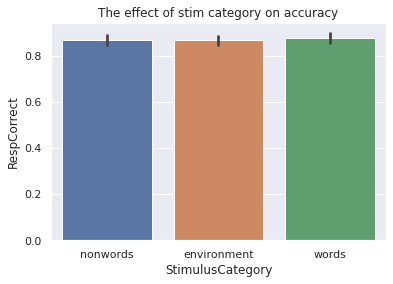

In [94]:
sns.barplot(x='StimulusCategory', y='RespCorrect', data = eeg_)
pl.title('The effect of stim category on accuracy');
print('NW vs W')
x, y = eeg_[eeg_['StimulusCategory'] == 'nonwords']['RespCorrect'], eeg_[eeg_['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))
print('NW vs Environment')
x, y = eeg_[eeg_['StimulusCategory'] == 'nonwords']['RespCorrect'], eeg_[eeg_['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('W vs Environment')
x, y = eeg_[eeg_['StimulusCategory'] == 'environment']['RespCorrect'], eeg_[eeg_['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=-3.255935675875266, pvalue=0.0011430205875872846)


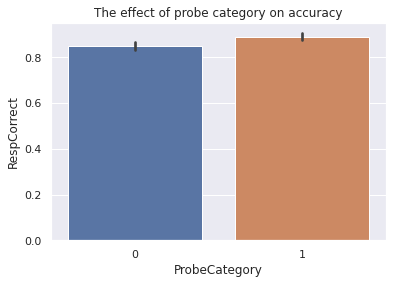

In [101]:
sns.barplot(x='ProbeCategory', y='RespCorrect', data = eeg_)
pl.title('The effect of probe category on accuracy');
print('0 vs 1')
x, y = eeg_[eeg_['ProbeCategory'] == 0]['RespCorrect'], eeg_[eeg_['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))

NW vs W
Ttest_indResult(statistic=1.4175576266968544, pvalue=0.1564786424891116)
NW vs Environment
Ttest_indResult(statistic=0.6911049314570566, pvalue=0.48958161573610814)
W vs Environment
Ttest_indResult(statistic=0.70557677153618, pvalue=0.48053567710421374)


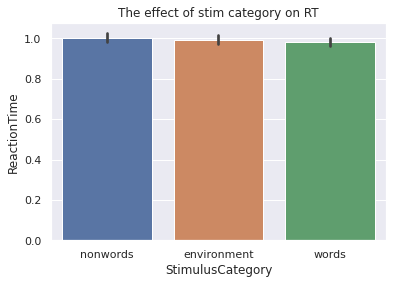

In [95]:
eeg_no_nones = eeg_[eeg_['Resp'] != 'None']
sns.barplot(x='StimulusCategory', y='ReactionTime', data = eeg_no_nones)
pl.title('The effect of stim category on RT');
print('NW vs W')
x, y = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))
print('NW vs Environment')
x, y = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('W vs Environment')
x, y = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime'], eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=5.467147264673293, pvalue=4.9621422878254886e-08)


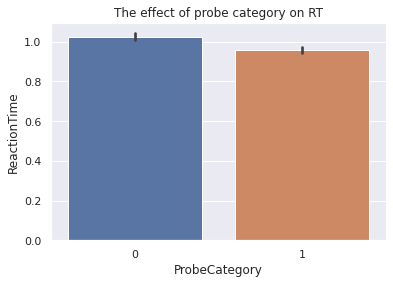

In [106]:
sns.barplot(x='ProbeCategory', y='ReactionTime', data = eeg_no_nones)
pl.title('The effect of probe category on RT');
print('0 vs 1')
x, y = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 0]['ReactionTime'], eeg_no_nones[eeg_no_nones['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))

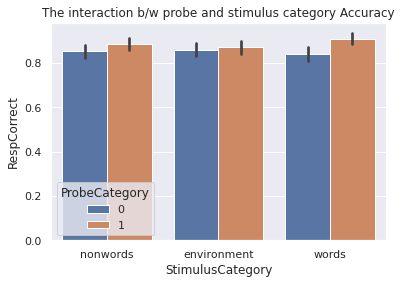

In [104]:
sns.barplot(x='StimulusCategory', y='RespCorrect', hue='ProbeCategory', data = eeg_)
pl.title('The interaction b/w probe and stimulus category Accuracy');

In [105]:
print('0 vs 1')
print('Nonwords')
subset = eeg_[eeg_['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Environment')
subset = eeg_[eeg_['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Words')
subset = eeg_[eeg_['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = eeg_[eeg_['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = eeg_[eeg_['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

0 vs 1
Nonwords
Ttest_indResult(statistic=array([-1.66955544]), pvalue=array([0.09532619]))
Environment
Ttest_indResult(statistic=array([-0.72983297]), pvalue=array([0.46566446]))
Words
Ttest_indResult(statistic=array([-3.28801405]), pvalue=array([0.00104629]))

NW vs W vs E
ProbeType 0
W vs NW Ttest_indResult(statistic=array([-0.43890204]), pvalue=array([0.66082771]))
W vs E Ttest_indResult(statistic=array([-0.70808498]), pvalue=array([0.47905815]))
NW vs E Ttest_indResult(statistic=array([0.26922055]), pvalue=array([0.78781573]))
ProbeType 1
W vs NW Ttest_indResult(statistic=array([1.18578064]), pvalue=array([0.23599518]))
W vs E Ttest_indResult(statistic=array([1.85698522]), pvalue=array([0.06361519]))
NW vs E Ttest_indResult(statistic=array([-0.67171276]), pvalue=array([0.50192317]))


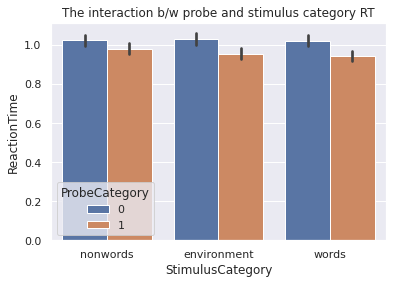

In [107]:
sns.barplot(x='StimulusCategory', y='ReactionTime', hue='ProbeCategory', data = eeg_no_nones)
pl.title('The interaction b/w probe and stimulus category RT');

In [ ]:
print('0 vs 1')
print('Nonwords')
subset = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Environment')
subset = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Words')
subset = eeg_[eeg_['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

## Accuracy plots. iEEG

NW vs W
Ttest_indResult(statistic=-1.33276703600682, pvalue=0.18277195121259818)
NW vs Environment
Ttest_indResult(statistic=1.9547055849256902, pvalue=0.05076665380139636)
W vs Environment
Ttest_indResult(statistic=-3.281640271071744, pvalue=0.0010513284448771408)


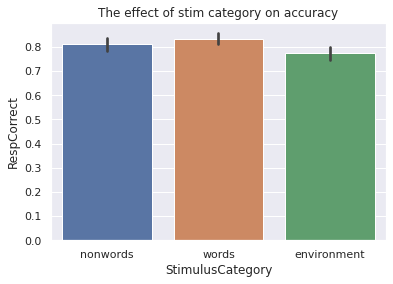

In [108]:
sns.barplot(x='StimulusCategory', y='RespCorrect', data = ieeg_)
pl.title('The effect of stim category on accuracy');
print('NW vs W')
x, y = ieeg_[ieeg_['StimulusCategory'] == 'nonwords']['RespCorrect'], ieeg_[ieeg_['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))
print('NW vs Environment')
x, y = ieeg_[ieeg_['StimulusCategory'] == 'nonwords']['RespCorrect'], ieeg_[ieeg_['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('W vs Environment')
x, y = ieeg_[ieeg_['StimulusCategory'] == 'environment']['RespCorrect'], ieeg_[ieeg_['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))

NW vs W
Ttest_indResult(statistic=1.3045545471130275, pvalue=0.192211304346207)
NW vs Environment
Ttest_indResult(statistic=-2.268332245067961, pvalue=0.023428038116147094)
W vs Environment
Ttest_indResult(statistic=3.590955475682147, pvalue=0.0003385530741545358)


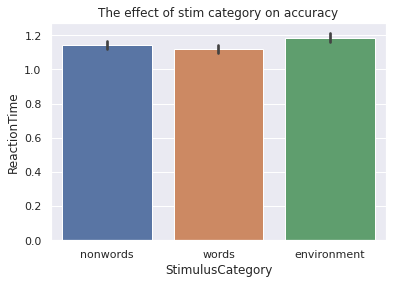

In [109]:
ieeg_no_nones = ieeg_[ieeg_['Resp'] != 'None']
sns.barplot(x='StimulusCategory', y='ReactionTime', data = ieeg_no_nones)
pl.title('The effect of stim category on accuracy');
print('NW vs W')
x, y = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))
print('NW vs Environment')
x, y = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('W vs Environment')
x, y = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime'], ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=-5.4723193205178955, pvalue=4.834994200097224e-08)


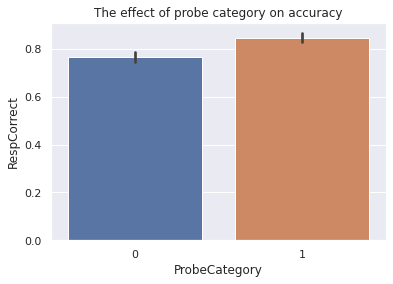

In [111]:
sns.barplot(x='ProbeCategory', y='RespCorrect', data = ieeg_)
pl.title('The effect of probe category on accuracy');
print('0 vs 1')
x, y = ieeg_[ieeg_['ProbeCategory'] == 0]['RespCorrect'], ieeg_[ieeg_['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=3.3064161710005484, pvalue=0.0009573788548153214)


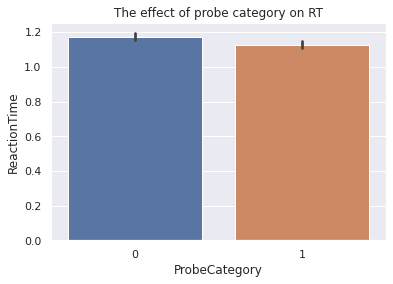

In [110]:
sns.barplot(x='ProbeCategory', y='ReactionTime', data = ieeg_no_nones)
pl.title('The effect of probe category on RT');
print('0 vs 1')
x, y = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 0]['ReactionTime'], ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))

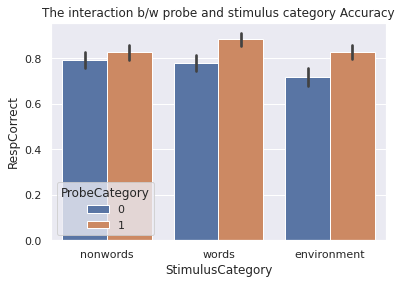

In [113]:
sns.barplot(x='StimulusCategory', y='RespCorrect', hue='ProbeCategory', data = ieeg_)
pl.title('The interaction b/w probe and stimulus category Accuracy');

In [116]:
print('0 vs 1')
print('Nonwords')
subset = ieeg_[ieeg_['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Environment')
subset = ieeg_[ieeg_['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Words')
subset = ieeg_[ieeg_['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = ieeg_[ieeg_['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = ieeg_[ieeg_['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

0 vs 1
Nonwords
Ttest_indResult(statistic=array([-1.26920503]), pvalue=array([0.20468448]))
Environment
Ttest_indResult(statistic=array([-4.01973387]), pvalue=array([6.30797129e-05]))
Words
Ttest_indResult(statistic=array([-4.23802791]), pvalue=array([2.49831899e-05]))

NW vs W vs E
ProbeType 0
W vs NW Ttest_indResult(statistic=array([-0.4442395]), pvalue=array([0.65697323]))
W vs E Ttest_indResult(statistic=array([2.22314849]), pvalue=array([0.02644715]))
NW vs E Ttest_indResult(statistic=array([-2.68450705]), pvalue=array([0.00739311]))
ProbeType 1
W vs NW Ttest_indResult(statistic=array([2.5559769]), pvalue=array([0.01075158]))
W vs E Ttest_indResult(statistic=array([2.50296304]), pvalue=array([0.01248996]))
NW vs E Ttest_indResult(statistic=array([0.05961015]), pvalue=array([0.95247886]))


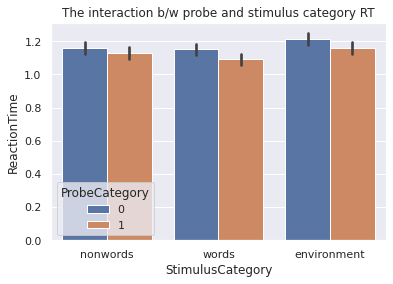

In [112]:
sns.barplot(x='StimulusCategory', y='ReactionTime', hue='ProbeCategory', data = ieeg_no_nones)
pl.title('The interaction b/w probe and stimulus category RT');

In [114]:
print('0 vs 1')
print('Nonwords')
subset = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Environment')
subset = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Words')
subset = eeg_[eeg_['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

0 vs 1
Nonwords
Ttest_indResult(statistic=array([1.25920067]), pvalue=array([0.20828174]))
Environment
Ttest_indResult(statistic=array([2.01863981]), pvalue=array([0.04382627]))
Words
Ttest_indResult(statistic=array([3.56736019]), pvalue=array([0.00037801]))

NW vs W vs E
ProbeType 0
W vs NW Ttest_indResult(statistic=array([-0.33013611]), pvalue=array([0.74137413]))
W vs E Ttest_indResult(statistic=array([-2.42561111]), pvalue=array([0.01548781]))
NW vs E Ttest_indResult(statistic=array([2.0665242]), pvalue=array([0.03907204]))
ProbeType 1
W vs NW Ttest_indResult(statistic=array([-1.48654885]), pvalue=array([0.13748458]))
W vs E Ttest_indResult(statistic=array([-2.69061565]), pvalue=array([0.00726362]))
NW vs E Ttest_indResult(statistic=array([1.1937202]), pvalue=array([0.23290088]))
